In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("names.txt","r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
#Vocab of letters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
#Builds dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [53]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147843647)
C = torch.randn((vocab_size, n_embd),generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden, generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

bngain = torch.ones((1, n_hid den))
bnbias = torch.zeros((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
bnmean_running = torch.zeros((1, n_hidden))
bnstd_ru nning = torch.ones((1, n_hidden))

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [55]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #Forward Pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    #Batch Norm
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    #Non linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #Track stats
    if i % 10000 == 0:  
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2994
  10000/ 200000: 1.9844
  20000/ 200000: 2.2819
  30000/ 200000: 2.2834
  40000/ 200000: 1.9281
  50000/ 200000: 2.2397
  60000/ 200000: 2.4237
  70000/ 200000: 2.4575
  80000/ 200000: 2.1833
  90000/ 200000: 2.1277
 100000/ 200000: 2.2026
 110000/ 200000: 1.8174
 120000/ 200000: 2.3717
 130000/ 200000: 1.8883
 140000/ 200000: 2.1838
 150000/ 200000: 1.7178
 160000/ 200000: 2.3558
 170000/ 200000: 1.8823
 180000/ 200000: 1.9537
 190000/ 200000: 2.1975


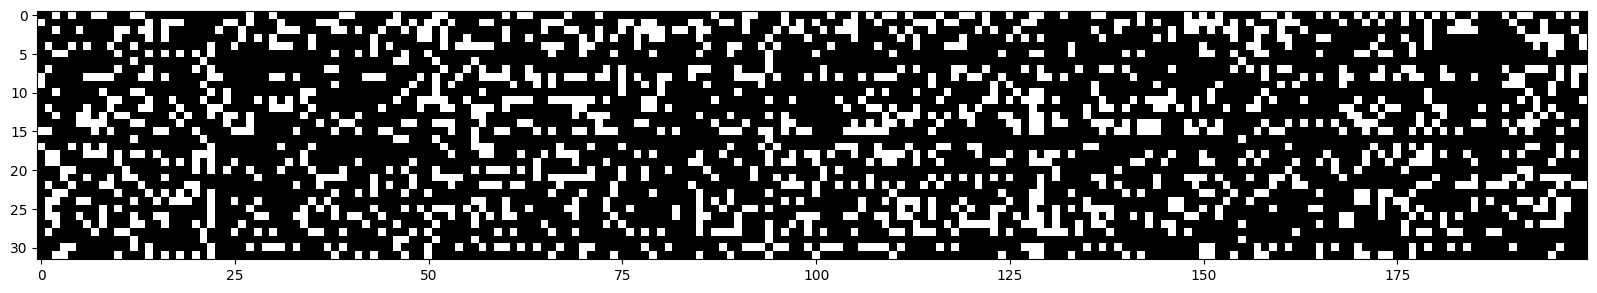

In [34]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

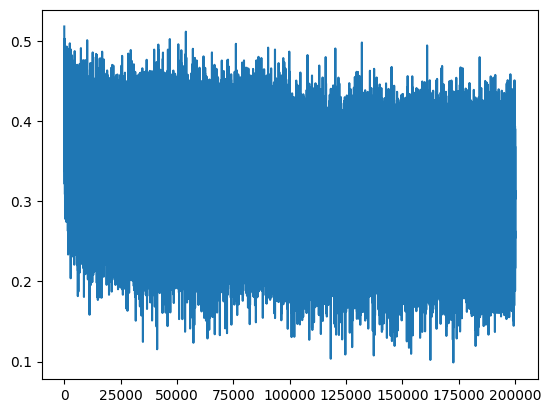

In [37]:
 plt.plot(lossi)

In [56]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [61]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067002296447754
val 2.1122848987579346


In [62]:
g = torch.Generator().manual_seed(2147843647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mankadlandeyszvaiglatzonzpstzabellnsinanzmmindkmarjqalizlellerzoentdynnquszuzmalqsarshysmarselmasszumatsabrlaniykaitzabriksxztxr.
laxzstyviahmi.
xzesmmatzawdlmrahmillysshuxzmmylviv.
grettyn.
viaunzpelmallhrzedszmanzvyviclkafpynsfmmizzaellansoymnirknazanimlaspvarvesremgrtragnderiztonfarkolliezarghlemmadciauvicamsefuddekancarladulumacellivsllhollighvibbyzsymanzatz.
marxdmillowandckswnoemmillhoxlmmadructhm.
nzftltmpt.
mayazppntlabbugrn.
maspengzlyssizzmirgeziah.
nleezrrgan.
manthlemarnakpshelleswstofsurhaudviksmarmckaspmikstiztsiezmardwle.
sazvizmarvikamerijdazsellhmixgan.
xtav.
malviassmizlyshmontzabsolswylexzfipjakansapxxqmiizaminlyvislytzfirmhirostineazsolzsclagnmylaanvikamuratzumiafzmirkthmmetzzncellykshadrkhllyaqoetzsmaviksliespzaseennnliezremmadshudwagsypfmckpyszvaquazsandevirxnlyviajamarrhnanstqughmstmarthm.
milubstafflellymixvackesmyelfsrpqudvruhmirlkebmyahmarshysonmfrybicburthe.
marraxstmariflytzjairrfmmethzalvah.
mikaislietkansamruvillaghmbrugncamiazyizlyssufztayanshkwndettlynzi